<a href="https://colab.research.google.com/github/waspar00/Gusev-2025/blob/main/Ex4-LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim
import torchvision as tv
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import gc
import numpy as np

In [5]:
#MNIST transform for lenet
transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,), (0.5,))])

In [9]:
#MNIST datasets loaders for lenet
train_set = tv.datasets.MNIST(root='./data', train = True, transform = transform, download = True)
test_set = tv.datasets.MNIST(root='./data', train = False, transform = transform, download = True)

class_names = train_set.classes

train_loader = DataLoader(train_set, batch_size = 2048, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 2048, shuffle = False)

In [10]:
#default lenet structure
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10 )

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        conv1_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool1_output = x
        x = nn.functional.relu(self.conv2(x))
        conv2_output = x
        x = nn.functional.avg_pool2d(x, 2)
        pool2_output = x
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x, conv1_output, pool1_output, conv2_output, pool2_output

In [44]:
#Modernized LeNet - max pooling
class CoolerLeNet(nn.Module):
    def __init__(self, num_classes):
        super(CoolerLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10 )

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        conv1_output = x
        x = nn.functional.max_pool2d(x, 2)
        pool1_output = x
        x = nn.functional.relu(self.conv2(x))
        conv2_output = x
        x = nn.functional.max_pool2d(x, 2)
        pool2_output = x
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x, conv1_output, pool1_output, conv2_output, pool2_output

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_eval(model, train_loader, test_loader, epochs, lr):
        model.train()
        training_losses = []
        validation_losses = []
        training_outputs = []
        validation_outputs = []

        criterion = nn.NLLLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        #optimizer = torch.optim.Adam(model.parameters, lr)

        for epoch in range(epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                training_outputs = model(inputs)

                loss = criterion(training_outputs[0], labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            training_losses.append(avg_training_loss)

            val_loss = 0.0

            model.eval()
            with torch.no_grad():
                for val_inputs, val_labels in test_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    validation_outputs = model(val_inputs)
                    val_loss += criterion(validation_outputs[0], val_labels).item()

            avg_validation_loss = val_loss / len(test_loader)
            validation_losses.append(avg_validation_loss)
            model.train()

            print(f"Epoch {epoch + 1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}")


        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in test_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                _, predicted = torch.max(outputs[0].data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        f1 = f1_score(all_labels, all_predictions, average='weighted')

        print(f"Accuracy: {accuracy}%")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
        plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='x')
        plt.title("Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


Epoch 1, Training Loss: 2.301332394282023, Validation Loss: 2.298819065093994
Epoch 2, Training Loss: 2.2966264804204304, Validation Loss: 2.293549680709839
Epoch 3, Training Loss: 2.2900291363398235, Validation Loss: 2.284462594985962
Epoch 4, Training Loss: 2.275579579671224, Validation Loss: 2.2603695392608643
Epoch 5, Training Loss: 2.2263912677764894, Validation Loss: 2.156412220001221
Epoch 6, Training Loss: 1.9071155468622842, Validation Loss: 1.413628888130188
Epoch 7, Training Loss: 0.8872579157352447, Validation Loss: 0.5164789915084839
Epoch 8, Training Loss: 0.41076766749223076, Validation Loss: 0.32430842220783235
Epoch 9, Training Loss: 0.3066510518391927, Validation Loss: 0.2610271781682968
Epoch 10, Training Loss: 0.25864324122667315, Validation Loss: 0.23835396766662598
Accuracy: 92.93%
Precision: 0.930792617875944
Recall: 0.9293
F1 Score: 0.9293067482428274


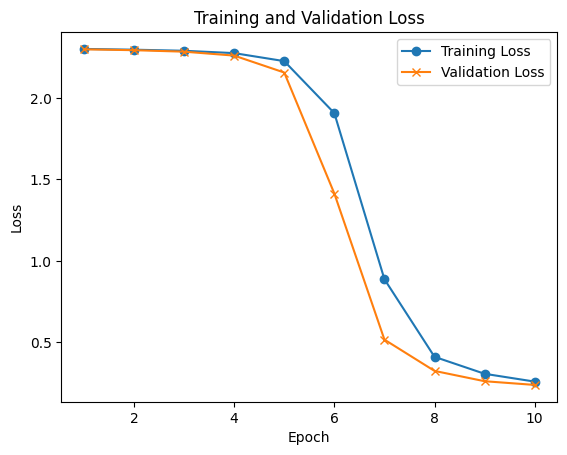

In [31]:
lenet = LeNet(len(class_names))
epochs = 10
learning_rate = 0.01
train_eval(lenet, train_loader, test_loader, epochs, learning_rate)

Epoch 1, Training Loss: 2.297723317146301, Validation Loss: 2.285589408874512
Epoch 2, Training Loss: 2.2625375509262087, Validation Loss: 2.212170124053955
Epoch 3, Training Loss: 1.962777308622996, Validation Loss: 1.2717276334762573
Epoch 4, Training Loss: 0.7280389855305354, Validation Loss: 0.44725061058998106
Epoch 5, Training Loss: 0.3944674720366796, Validation Loss: 0.31002241671085357
Epoch 6, Training Loss: 0.2885255659619967, Validation Loss: 0.2334162950515747
Epoch 7, Training Loss: 0.22983976155519487, Validation Loss: 0.19011629819869996
Epoch 8, Training Loss: 0.19286959618330002, Validation Loss: 0.16276129484176635
Epoch 9, Training Loss: 0.16955645779768627, Validation Loss: 0.14267707914113997
Epoch 10, Training Loss: 0.14743164678414664, Validation Loss: 0.13176873922348023
Accuracy: 96.05%
Precision: 0.960718334512517
Recall: 0.9605
F1 Score: 0.9604508602785703


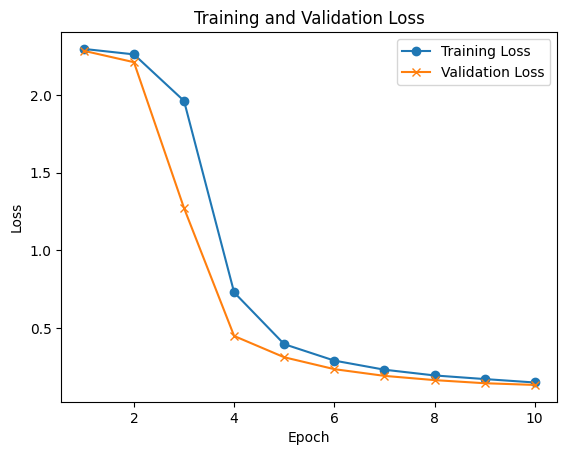

In [45]:
lenet = CoolerLeNet(len(class_names))
epochs = 10
learning_rate = 0.01
train_eval(lenet, train_loader, test_loader, epochs, learning_rate)